In [1]:
import warnings
warnings.filterwarnings('ignore')

## Installing External Packages

The lines starting with pip install tell our notebook to download specific software packages from the internet that are not included by default. We are downloading tools like Hugging Face to load our massive artificial intelligence models, FAISS to perform high speed database searches for past patients, and Gradio to build our final web dashboard that the doctors will use.

In [2]:
!pip install -q huggingface_hub
!pip install faiss-cpu
!pip install -q shap
!pip install -q umap-learn
!pip install gradio
!pip install -q transformers>=4.50.0 accelerate  huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 66.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 11.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s eta 0:00:0000:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.5
    Uninstalling pydantic_core-2.41.5:
      Successfully uninstalled pydantic_core-2.41.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.5
    Uninstalling pydantic-2.12.5:
      Successfully uninstalled pydantic-2.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
langchain-core 0.3.79 requires packaging<26.0.0,>=23

In [3]:
import os
import cv2
import time
import umap
import faiss
import torch
import gdown
import random
import kagglehub
import numpy as np
import gradio as gr
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from huggingface_hub import snapshot_download, login
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, roc_curve, auc
from transformers import AutoProcessor, AutoModel, AutoModelForImageTextToText


2026-02-24 12:29:22.102916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771936162.305136      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771936162.362454      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771936162.855533      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771936162.855585      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771936162.855588      55 computation_placer.cc:177] computation placer alr

## Loading Pre-Processed Data

Extracting features from thousands of medical images takes over 10 hours. To save time and avoid repeating this heavy processing, we already extracted the data and saved it to Google Drive. This code simply downloads those pre-computed files directly into our workspace so we can start training our model immediately.

In [4]:
train_emb = "1QyZQLcgQEwpZpEBaMuMSzlrVlaUvkqXA"
train_label = "1ig2b0QLpe3aMxScDE_YkxPaoqndGs3Ro"

val_emb = "1rBXFcqdQy-1jwScd8jlb0YSL-5CgZZBk"
val_label = "177eCaDuBOkGViTnSURZh4a688-z4VJN1"

test_emb = "1KfD_qioCSRg0AD1NBDB2Ch6d_tOBZNfb"
test_label = "1QiW79lxCc4_d2wuj9bL7NJEm88XJ5yjs"

files = {"train_emb":train_emb, "train_label":train_label, "val_emb":val_emb, "val_label":val_label, "test_emb":test_emb, "test_label":test_label}
for file in files:
    url = f"https://drive.google.com/uc?id={files.get(file)}"
    
    gdown.download(url, f"{file}.npy", quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=1QyZQLcgQEwpZpEBaMuMSzlrVlaUvkqXA
From (redirected): https://drive.google.com/uc?id=1QyZQLcgQEwpZpEBaMuMSzlrVlaUvkqXA&confirm=t&uuid=f15e9457-d52b-4743-9d0b-f81afe85089f
To: /kaggle/working/train_emb.npy
100%|██████████| 945M/945M [00:26<00:00, 35.4MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ig2b0QLpe3aMxScDE_YkxPaoqndGs3Ro
To: /kaggle/working/train_label.npy
100%|██████████| 616k/616k [00:00<00:00, 88.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rBXFcqdQy-1jwScd8jlb0YSL-5CgZZBk
From (redirected): https://drive.google.com/uc?id=1rBXFcqdQy-1jwScd8jlb0YSL-5CgZZBk&confirm=t&uuid=88bc5cf9-be9c-4449-940e-c899052d74d9
To: /kaggle/working/val_emb.npy
100%|██████████| 118M/118M [00:01<00:00, 76.5MB/s] 
Downloading...
From: https://drive.google.com/uc?id=177eCaDuBOkGViTnSURZh4a688-z4VJN1
To: /kaggle/working/val_label.npy
100%|██████████| 77.0k/77.0k [00:00<00:00, 48.8MB/s]
Downloading...
Fro

## Authenticating and Hardware Setup

To download restricted AI models like MedGemma, we first need to log in to Hugging Face using a secure access token.

After logging in, the code checks if a GPU (cuda) is available on our machine. A GPU acts as a supercharger, allowing our heavy AI models to run much faster than they would on a standard CPU.

In [5]:
HF_TOKEN = "***"
login(token=HF_TOKEN)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Eye 1: Google Path Foundation Model
This block downloads and loads the Google Path model. This model acts as our first eye, specialized in understanding the broad, overall structure of human tissue slides.

## Eye 2: MedSigLIP
This block loads the MedSigLIP model. This acts as our second eye, designed to capture very fine, specific medical details that the first model might miss.

## Main Vision-Language Model (The Scribe)
Here, we load MedGemma 1.5, which is a powerful large language model trained on medical data. Instead of making the diagnosis itself, MedGemma will act as our clinical scribe. It will look at the mathematical results and visual evidence from the other models to write the final, human-readable pathology report.

In [6]:
# Path Foundation Model (eye 1)

try:
    model_path = snapshot_download(repo_id="google/path-foundation")
    print(f"Downloaded to: {model_path}")
    
    path_model = tf.saved_model.load(model_path)
    print("The Google Path Foundation Model is loaded!")

except Exception as e:
    print(f"\nError: {e}")

# MediSigLIP (eye 2)

MEDSIGLIP_ID = "google/medsiglip-448" 
try:
    medsiglip_processor = AutoProcessor.from_pretrained(MEDSIGLIP_ID)
    medsiglip_model = AutoModel.from_pretrained(
        MEDSIGLIP_ID, 
        trust_remote_code=True,
        torch_dtype=torch.float16 
    ).to(device)
    
    medsiglip_model.eval()
    print("-> MedSigLIPLoaded Successfully!")

except Exception as e:
    print(f"\n X -> ERROR: Could not load MedSigLIP. Reason: {e}")


# MedGemma (Main Model VLM)


MEDGEMMA_ID = "google/medgemma-1.5-4b-it"
medgemma_processor = AutoProcessor.from_pretrained(MEDGEMMA_ID)

medgemma_model = AutoModelForImageTextToText.from_pretrained(
    MEDGEMMA_ID,
    torch_dtype=torch.bfloat16
).to(device)
medgemma_model.eval()
print("-> MedGemma successfully reloaded!\n")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

variables/variables.data-00000-of-00001:   0%|          | 0.00/110M [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/3.64k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Test.png:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloaded to: /root/.cache/huggingface/hub/models--google--path-foundation/snapshots/b50f2be6f055ea6ea8719f467ab44b38f37e2142


I0000 00:00:1771936238.872208      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


The Google Path Foundation Model is loaded!


preprocessor_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

-> MedSigLIPLoaded Successfully!


processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

-> MedGemma successfully reloaded!



.

# Loading data

In [7]:
BASE_DIR = "/kaggle/input/datasets/linjustin/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss"
BATCH_SIZE = 64 
IMG_SIZE = (224, 224)


def create_dataset(directory):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        shuffle=False,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='int'
    )

train_ds = create_dataset(os.path.join(BASE_DIR, 'train'))
val_ds   = create_dataset(os.path.join(BASE_DIR, 'val'))
test_ds  = create_dataset(os.path.join(BASE_DIR, 'test'))



Found 153849 files belonging to 2 classes.
Found 19230 files belonging to 2 classes.
Found 19233 files belonging to 2 classes.


## Extracting and Saving Visual Features

This function processes our medical images through both of our vision models Google Path(Eye1) and MedSigLIP(Eye2). 

It extracts the mathematical patterns from both combines them into a single, rich data profile, and saves the final results to a file. This ensures we only have to perform this heavy computing task once.

In [16]:
# Eye 1: Google Path Foundation Model.

def extract_path_features(image_tensor, path_serve_function):

    # Pass the formatted image through the path model
    outputs = path_serve_function(image_tensor)
    
    # Extract the raw mathematical numbers
    path_embeddings = outputs['output_0'].numpy()
    
    return path_embeddings

In [17]:
# Eye 2: MedSigLIP Model

def extract_medsiglip_features(image_list, processor, vision_model, device="cuda"):

    # Prepare the image for the MedSigLIP model format
    inputs = processor(images=image_list, return_tensors="pt").to(device)
    
    # Use bfloat16 or float16 to save computer memory
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

    # Extract the visual features without changing the model weights
    with torch.no_grad():
        outputs = vision_model.vision_model(inputs["pixel_values"])
        med_embeddings = outputs.pooler_output.float().cpu().numpy()
        
    return med_embeddings

In [18]:
# The Fusion Center

def fuse_features(path_vector, medsiglip_vector):

    # Join the two sets of numbers side by side
    fused_vector = np.concatenate([path_vector, medsiglip_vector], axis=1)
    
    return fused_vector

In [19]:
# Master Extraction Controller.

def get_fused_embedding_modular(image_array, path_serve_fn, processor, vision_model, device="cuda"):
    # 1. Format image for Google Path
    tensor_tf = tf.expand_dims(image_array, 0) / 255.0
    
    # 2. Extract from Eye 1
    embed_path = extract_path_features(tensor_tf, path_serve_fn)
    
    # 3. Format image for MedSigLIP 
    image_list = [image_array.astype(np.uint8)]
    
    # 4. Extract from Eye 2
    embed_med = extract_medsiglip_features(image_list, processor, vision_model, device)
    
    # 5. Fuse the features together
    final_fused_vector = fuse_features(embed_path, embed_med)
    
    return final_fused_vector

In [20]:
def extract_and_save(dataset, name):

    all_embeddings = []
    all_labels = []
    start_time = time.time()
    
    # Get the Google Path function ready
    serve_fn = path_model.signatures['serving_default']
    
    for step, (images, labels) in enumerate(dataset):        
        # Prepare and Extract using Eye 1 (Google Path) 
        images_tf = tf.cast(images, tf.float32) / 255.0
        embeddings_path = extract_path_features(images_tf, serve_fn)

        # Prepare and Extract using Eye 2 (MedSigLIP)
        images_list = list(images.numpy().astype(np.uint8))
        embeddings_med = extract_medsiglip_features(
            images_list, 
            medsiglip_processor, 
            medsiglip_model, 
            device
        )

        # The Fusion Center 
        embeddings_fused = fuse_features(embeddings_path, embeddings_med)
        
        # Store the results for this batch 
        all_embeddings.append(embeddings_fused)
        all_labels.append(labels.numpy())

        if step % 10 == 0:
            print(f"   Batch {step}: Processed {step * len(images)} images...")

    # Combine everything into one massive dataset 
    X = np.vstack(all_embeddings)
    y = np.concatenate(all_labels)
    
    # Save to disk so we don't have to compute this again 
    np.save(f'{name}_embeddings.npy', X)
    np.save(f'{name}_labels.npy', y)
    
    duration = time.time() - start_time
    print(f"Finished {name} in {duration:.1f} seconds.")
    print(f"Final Shape: {X.shape}")
    
    return X, y

I aleady extracted all embbedings using upper function and downloaded that embbedings from google drive.

In [21]:
X_train = np.load('train_emb.npy')
y_train = np.load('train_label.npy')

X_val = np.load('val_emb.npy')
y_val = np.load('val_label.npy')

X_test = np.load('test_emb.npy')
y_test = np.load('test_label.npy')

In [22]:
dim = X_train.shape[1]

## The Mathematical Classifier

This section builds our custom neural network. It acts as the main decision-maker. 

It takes the combined data from our two vision models and passes it through several layers of mathematical filters to learn the complex patterns of the cancer. 

The final output is a simple probability score, predicting whether the tissue is MSI-High or MSS. We added **Dropout** layers to prevent the network from just memorizing the images, forcing it to learn genuine biological rules.

In [23]:
def mlp1(input_dim=dim):
    model = models.Sequential([
        layers.InputLayer(shape=(input_dim,)),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

## Training Classifier

In [24]:
mlp1_model = mlp1()

early_stop = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

checkpoint = callbacks.ModelCheckpoint('chrono_glionet_best.keras', monitor='val_auc', mode='max', save_best_only=True)


history = mlp1_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, 
    batch_size=128, 
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


I0000 00:00:1771936719.685511     191 service.cc:152] XLA service 0x78dee4006c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771936719.685557     191 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771936720.358364     191 cuda_dnn.cc:529] Loaded cuDNN version 91002


  37/1202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6066 - auc: 0.6420 - loss: 0.7930

I0000 00:00:1771936723.844716     191 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1202/1202 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8147 - auc: 0.8876 - loss: 0.4059 - val_accuracy: 0.9123 - val_auc: 0.9744 - val_loss: 0.1995
Epoch 2/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9047 - auc: 0.9674 - loss: 0.2235 - val_accuracy: 0.9365 - val_auc: 0.9856 - val_loss: 0.1520
Epoch 3/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9236 - auc: 0.9780 - loss: 0.1837 - val_accuracy: 0.9457 - val_auc: 0.9886 - val_loss: 0.1333
Epoch 4/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9347 - auc: 0.9834 - loss: 0.1591 - val_accuracy: 0.9496 - val_auc: 0.9911 - val_loss: 0.1197
Epoch 5/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9411 - auc: 0.9864 - loss: 0.1444 - val_accuracy: 0.9544 - val_auc: 0.9922 - val_loss: 0.1115
Epoch 6/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9465 - auc: 0.9884 - loss: 0.1326 - val_accuracy: 0.9575 - val_auc: 0.9929 - val_loss: 0.1046
Epoch 7/30
1202/1202 ━━━━━━━━━━━━━━━━━

602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9703 - auc: 0.6104 - loss: 0.0802
TEST ACCURACY: 97.63%


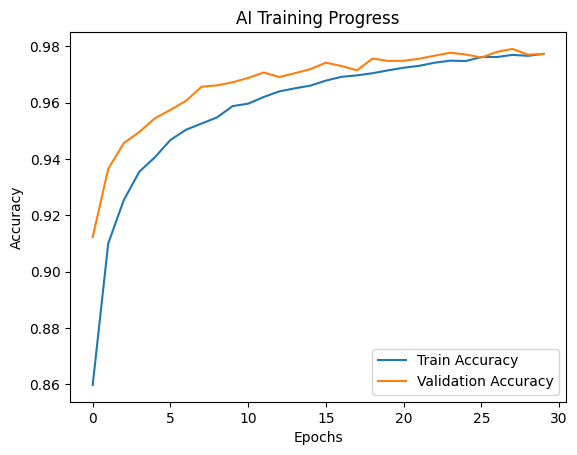

In [25]:
loss, acc, _ = mlp1_model.evaluate(X_test, y_test)

print(f"TEST ACCURACY: {acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('AI Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Evaluating Model Performance
After training our artificial intelligence, we must test it on brand new patient images it has never seen before. This code calculates the final accuracy and draws two important performance charts.

**Confusion Matrix** 
* This shows exactly how many predictions were correct and exactly where the model made mistakes. 

**ROC Curve** 
* This measures how well the model can tell the difference between the MSI High cases and the MSS cases. These charts prove that our model works in the real world.

In [ ]:

test_loss, test_acc, test_auc = mlp1_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test AUC:      {test_auc:.4f}\n")


y_pred_probs = mlp1_model.predict(X_test).ravel()
y_pred_classes = (y_pred_probs > 0.5).astype(int)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
            xticklabels=['MSS (0)', 'MSI-High (1)'], 
            yticklabels=['MSS (0)', 'MSI-High (1)'])
axes[0].set_title('Test Set Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('Actual Pathology')
axes[0].set_xlabel('AI Prediction')


#ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC', fontweight='bold')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## Building the Historical Case Database
To find similar past patients instantly, we need a high speed search engine. This code uses a powerful tool called **FAISS (Facebook AI Similarity Search)**. 

It takes the mathematical profiles of all our past patients, standardizes the numbers, and loads them into a highly organized index.

This step gives our AI a memory. It creates a searchable database of over 153849 historical cases allowing the system to find the closest matching past patients in a fraction of a second.

In [26]:
# CASE-BASED REASONING (FAISS DATABASE)

def build_faiss_database(train_vectors, vector_dimension):
    # Convert to float32 (FAISS requires this specific format for speed)
    database_embeddings = train_vectors.astype('float32')
    
    # Normalize the math so we measure true pattern shape (Cosine Similarity)
    faiss.normalize_L2(database_embeddings)
    
    # Build the blank index and load all historical patient data into it
    index = faiss.IndexFlatL2(vector_dimension)
    index.add(database_embeddings)
    
    return index

index = build_faiss_database(X_train, dim)
print(f"Search Engine Ready! Total past patients loaded: {index.ntotal}")

Search Engine Ready! Total past patients loaded: 153849


## Testing the Search Engine Accuracy

This function tests how smart our historical database really is. 
It takes a set of new test images, finds their top five closest matches in the database and looks at their medical labels. It then checks if the majority of those past patients have the exact same disease as the new test patient.

In [27]:

def evaluate_retrieval_system(index, query_vecs, true_labels, database_labels, k=5):
    print("searching ...")
  
    D, I = index.search(query_vecs, k)
    
    neighbor_labels = database_labels[I] 
    
    
    predicted_labels, _ = mode(neighbor_labels, axis=1, keepdims=True)
    predicted_labels = predicted_labels.flatten()
    
    correct_retrievals = np.sum(predicted_labels == true_labels)
    top_k_accuracy = correct_retrievals / len(true_labels)
    
    return top_k_accuracy, correct_retrievals


In [ ]:
query_embeddings = X_test.astype('float32')

In [50]:
k_val = 5
acc, correct = evaluate_retrieval_system(index, query_embeddings, y_test, y_train, k=k_val)

print(f"Total Test Images: {len(y_test)}")
print(f"Correct Retrievals: {correct}")

print(f"Top-{k_val} Accuracy: {acc:.2%}")

if acc > 0.90:
    print("- Conclusion: Your embedding space is HIGHLY SEMANTIC.")
    print("   (Similar patients almost always share the same diagnosis.)")
else:
    print("- Conclusion: Embeddings are somewhat noisy.")

searching ...
Total Test Images: 19233
Correct Retrievals: 18383
Top-5 Accuracy: 95.58%
- Conclusion: Your embedding space is HIGHLY SEMANTIC.
   (Similar patients almost always share the same diagnosis.)


## Visualizing the AI's Knowledge

High-dimensional mathematics is impossible for the human eye to see. This code uses a visualization tool called UMAP to squash the complex mathematical profiles of 2000 patients down into a simple 2D map.

We plot these patients as dots, coloring the MSI-High patients red and the MSS patients blue. If the red and blue dots form clearly separated groups on the graph, it visually proves that our artificial intelligence has successfully learned the difference between the two types of cancer.

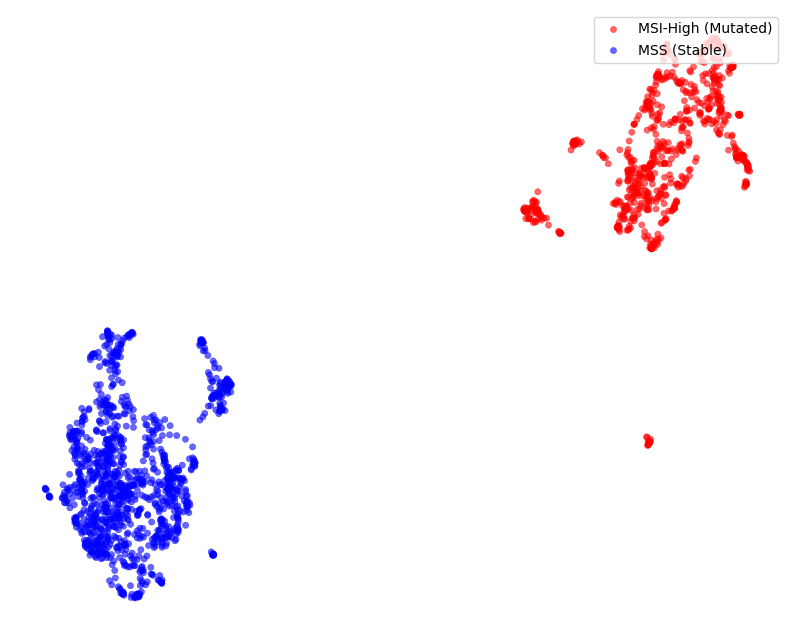

In [32]:
subset_size = 2000
indices = np.random.choice(len(query_embeddings), subset_size, replace=False)

X_subset = query_embeddings[indices]
y_subset = y_test[indices]

labels_text = ["MSI-High (Mutated)" if y==0 else "MSS (Stable)" for y in y_subset]

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(X_subset, y=y_subset) 

plt.figure(figsize=(10, 8))
df_sup = pd.DataFrame({
    'UMAP Dimension 1': embedding[:, 0],
    'UMAP Dimension 2': embedding[:, 1],
    'Diagnosis': labels_text
})

sns.scatterplot(
    data=df_sup,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    hue='Diagnosis',
    palette={"MSI-High (Mutated)": "red", "MSS (Stable)": "blue"},
    alpha=0.6,
    s=20,
    edgecolor=None
)

plt.legend(loc='upper right')
plt.axis('off')

plt.show()

## Generating the Visual Evidence Map

This function is the core of our Explainable AI. To prove why the model made a specific diagnosis it slides a small blank square across the image, hiding tiny groups of cells one by one.

If hiding a certain area causes the AI to lose confidence in its prediction, the system knows those specific cells are the most important. It calculates the importance of every single patch and generates a bright heatmap (red for mutated, green for stable). This visual proof is exactly what the doctor needs to trust the AI's decision.

In [28]:
# The Occlusion Engine.
# This tool slides a blank gray square across the image to hide small groups of cells.

def generate_raw_heatmap(image_array, baseline_msi_risk, mode, path_serve_fn, processor, vision_model, classifier_model, device="cuda"):

    height, width, _ = image_array.shape
    heatmap = np.zeros((height, width))
    
    patch_size = 40  
    stride = 20      
    
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # 1. Hide a small square
            masked_img = image_array.copy()
            masked_img[y:y+patch_size, x:x+patch_size] = 128 
            
            # 2. Check the new AI prediction
            masked_embed = get_fused_embedding_modular(
                masked_img, path_serve_fn, processor, vision_model, device
            )
            masked_mss_prob = classifier_model.predict(masked_embed, verbose=0)[0][0]
            masked_msi_risk = 1.0 - masked_mss_prob
            
            # 3. Calculate importance
            if mode == "RED_MODE":
                importance = baseline_msi_risk - masked_msi_risk
            else: 
                importance = masked_msi_risk - baseline_msi_risk

            if importance < 0: importance = 0
            heatmap[y:y+patch_size, x:x+patch_size] += importance

    return heatmap

In [29]:
# The Visual Polish.
# This takes the raw mathematical numbers and smooths them into a beautiful,
# easy to read medical overlay. It only keeps the top 20 percent most important cells.


def smooth_and_filter_heatmap(raw_heatmap):

    max_importance = np.max(raw_heatmap)
    if max_importance == 0:
        return raw_heatmap
        
    heatmap_final = raw_heatmap / max_importance
    heatmap_final = cv2.GaussianBlur(heatmap_final, (11, 11), 0)
    
    threshold = np.percentile(heatmap_final, 80)
    heatmap_final = np.where(heatmap_final > threshold, heatmap_final, 0)
    
    if np.max(heatmap_final) > 0:
        heatmap_final = heatmap_final / np.max(heatmap_final)
        
    return heatmap_final

In [30]:
# Explainability Controller
# Loads a patient image, gets the primary diagnosis, and generates the visual proof.

def explain_dual_channel(image_path, path_model, medsiglip_model, medsiglip_processor, classifier_model, device="cuda"):

    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    path_serve_fn = path_model.signatures['serving_default']
    
    base_embed = get_fused_embedding_modular(
        img_array, path_serve_fn, medsiglip_processor, medsiglip_model, device
    )
    
    mss_prob = classifier_model.predict(base_embed, verbose=0)[0][0]
    msi_risk = 1.0 - mss_prob
    
    mode = "RED_MODE" if msi_risk > 0.50 else "GREEN_MODE" 
        
    raw_heatmap = generate_raw_heatmap(
        img_array, msi_risk, mode, path_serve_fn, medsiglip_processor, medsiglip_model, classifier_model, device
    )
    heatmap_final = smooth_and_filter_heatmap(raw_heatmap)

    return img, heatmap_final, msi_risk, mode, base_embed

## It helps to plot the heatmap

In [31]:
def plot_heatmap(img, heatmap, score, mode, title_prefix):
    fig = plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(img).astype("uint8"))
    plt.title(f"{title_prefix}\n(AI Risk: {score:.1%})", fontweight='bold')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.array(img).astype("uint8"))
    
    if mode == "RED_MODE":
        plt.imshow(heatmap, cmap='Reds', alpha=0.6)
        plt.title(f"EVIDENCE (MSI-HIGH)", fontweight='bold')
    else:
        plt.imshow(heatmap, cmap='Greens', alpha=0.6)
        plt.title(f"EVIDENCE (MSS)", fontweight='bold')
        
    plt.axis('off')
    plt.tight_layout()
    return fig

## The Master Application Logic

This function acts as the central brain of our software. 
It connects all the individual pieces we have built. When a doctor uploads a new image, this function takes over. It runs the dual vision models, makes the mathematical prediction, draws the visual heat maps, asks MedGemma to write the clinical report, and retrieves the three matching past patients from the database. It gathers all this information into one complete package.


## Building the Web Dashboard
This final section creates the actual user interface using Gradio. Instead of forcing doctors to read computer code, this builds a clean and professional web page.

It organizes the screen into clear columns. The doctor simply uploads an image on the left and clicks one button. The right side of the screen immediately displays the diagnosis, the visual map, the MedGemma written report, and the matching past cases. The final launch command turns the entire system on and makes it live on the internet.

In [32]:
# THE MASTER PIPELINE & GRADIO DASHBOARD

def process_patient_dashboard(query_image_path):
    
    # --- A. PROCESS CURRENT PATIENT ---
    q_img, q_heatmap, q_score, q_mode, q_embed = explain_dual_channel(
        query_image_path, path_model, medsiglip_model, medsiglip_processor, mlp1_model, device="cuda"
    )
    
    q_diagnosis = "MSI-High (Mutated)" if q_mode == "RED_MODE" else "MSS (Stable)"
    q_conf = q_score if q_mode == "RED_MODE" else 1.0 - q_score
    q_text = f"PREDICTION: {q_diagnosis}\nCONFIDENCE: {q_conf*100:.2f}%"
    q_fig = plot_heatmap(q_img, q_heatmap, q_score, q_mode, "Current Patient")

    # --- B. FAISS RETRIEVAL (Run FIRST to get evidence for MedGemma) ---

    patient_vec = q_embed.astype('float32').copy()
    faiss.normalize_L2(patient_vec)
    
    distances, indices = index.search(patient_vec, 3)
    similar_patients = indices[0]
    
    ref_plots = []
    ref_texts = []
    faiss_context_text = "" # Build evidence string for MedGemma
    
    for i in range(3):
        neighbor_id = similar_patients[i]
        neighbor_class = int(y_train[neighbor_id])
        neighbor_name = "MSI-High" if neighbor_class == 0 else "MSS"
        
        l2_distance = distances[0][i]
        match_percentage = max(0.0, 1.0 - (l2_distance / 2.0)) * 100.0
        
        print(f"   * Explaining Case #{neighbor_id}...")
        ref_path = train_image_paths[neighbor_id] 
        
        r_img, r_heatmap, r_score, r_mode, _ = explain_dual_channel(
            ref_path, path_model, medsiglip_model, medsiglip_processor, mlp1_model, device="cuda"
        )
        
        r_fig = plot_heatmap(r_img, r_heatmap, r_score, r_mode, f"Historical Case #{neighbor_id}")
        r_text = f"DATABASE MATCH #{i+1}\nPatient ID: {neighbor_id}\nGround Truth: {neighbor_name}\nMorphological Match: {match_percentage:.1f}%"
        
        ref_plots.append(r_fig)
        ref_texts.append(r_text)
        faiss_context_text += f"- Case #{neighbor_id}: {neighbor_name} (Match: {match_percentage:.1f}%)\n"

    # RUN MEDGEMMA 4B REPORT (Armed with FAISS Context) 

    base_img_uint8 = np.array(q_img).astype(np.uint8)
    heatmap_norm = q_heatmap / (np.max(q_heatmap) + 1e-9)
    
    cmap = plt.get_cmap('Reds') if q_mode == "RED_MODE" else plt.get_cmap('Greens')
    highlight_color = "red" if q_mode == "RED_MODE" else "green"
        
    heatmap_color = (cmap(heatmap_norm)[:, :, :3] * 255).astype(np.uint8)
    blended_array = cv2.addWeighted(base_img_uint8, 0.7, heatmap_color, 0.6, 0)
    blended_pil = Image.fromarray(blended_array)

    messages_guided = [
        {"role": "user", "content": [
            {"type": "image"}, 
            {"type": "text", "text": f"You are an expert clinical pathologist. Our primary mathematical AI has diagnosed this colorectal H&E slide as {q_diagnosis} with {q_conf*100:.1f}% confidence. The AI has highlighted the specific cellular evidence in {highlight_color}.\n\nTo visually verify this, our Case-Based Reasoning system retrieved the 3 most biologically similar historical patients from a database of 150,000 cases. The historical matches are:\n{faiss_context_text}\nWrite a concise pathology report describing the specific cellular morphology in the {highlight_color} highlighted regions that justify this {q_diagnosis} diagnosis. Conclude by briefly explaining how the historical FAISS database matches support this finding."}
        ]}
    ]

    prompt_guided = medgemma_processor.apply_chat_template(messages_guided, tokenize=False, add_generation_prompt=True)
    inputs_guided = medgemma_processor(text=prompt_guided, images=[blended_pil], return_tensors="pt").to(device)
    inputs_guided["pixel_values"] = inputs_guided["pixel_values"].to(torch.bfloat16)
    
    with torch.inference_mode():
        outputs_guided = medgemma_model.generate(**inputs_guided, max_new_tokens=300)
    
    input_length = inputs_guided.input_ids.shape[1]
    report = medgemma_processor.decode(outputs_guided[0][input_length:], skip_special_tokens=True).strip()

    return q_fig, q_text, report, ref_plots[0], ref_texts[0], ref_plots[1], ref_texts[1], ref_plots[2], ref_texts[2]



In [34]:

train_image_paths = train_ds.file_paths 
# GRADIO UI 
custom_theme = gr.themes.Soft(
    font=[gr.themes.GoogleFont("Inter"), "ui-sans-serif", "system-ui", "sans-serif"],
    primary_hue="indigo",
    secondary_hue="blue"
)

with gr.Blocks(theme=custom_theme) as demo:
    gr.Markdown("# GemmaSight: Multi-Modal Pathology Assistant")
    gr.Markdown("Upload an H&E slide. \nGemmaSight will extract visual features, generate spatial occlusion heatmaps, retrieve similar historical cases from FAISS, and use MedGemma to draft an evidence-backed clinical report.")
    
    with gr.Row():
        with gr.Column(scale=1):
            img_input = gr.Image(type="filepath", label="Upload New Patient Slide")
            analyze_btn = gr.Button("Analyze & Find Similar Cases", variant="primary")
            
        with gr.Column(scale=2):
            q_text_output = gr.Textbox(label="AI Diagnosis & Confidence", lines=2)
            q_plot_output = gr.Plot(label="Query Saliency Map")
            medgemma_output = gr.Textbox(label="MedGemma 4B Clinical Report", lines=6)
            
    gr.Markdown("---")
    gr.Markdown("### Similar Historical Cases")
    
    with gr.Row():
        with gr.Column():
            r1_text = gr.Textbox(label="Case 1 Match", lines=4)
            r1_plot = gr.Plot(label="Case 1 Maps")
        with gr.Column():
            r2_text = gr.Textbox(label="Case 2 Match", lines=4)
            r2_plot = gr.Plot(label="Case 2 Maps")
        with gr.Column():
            r3_text = gr.Textbox(label="Case 3 Match", lines=4)
            r3_plot = gr.Plot(label="Case 3 Maps")
            
    analyze_btn.click(
        fn=process_patient_dashboard, 
        inputs=img_input, 
        outputs=[q_plot_output, q_text_output, medgemma_output, r1_plot, r1_text, r2_plot, r2_text, r3_plot, r3_text]
    )

demo.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://ee10b955ba56977ce1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

   * Explaining Case #36256...
   * Explaining Case #45896...
   * Explaining Case #54033...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr

   * Explaining Case #85149...
   * Explaining Case #74468...
   * Explaining Case #92207...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ee10b955ba56977ce1.gradio.live
